In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [3]:
torch.manual_seed(42)

In [4]:
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same")
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same")
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same")
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=64)
        self.dropout2 = nn.Dropout(p=0.3)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same")
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same")
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.bn5 = nn.BatchNorm2d(num_features=128)
        self.bn6 = nn.BatchNorm2d(num_features=128)
        self.dropout3 = nn.Dropout(p=0.4)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=2048, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=128)
        self.bn7 = nn.BatchNorm1d(num_features=128)
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=128, out_features=10)
        
        
    def forward(self, x):
        outputs = []
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        outputs.append(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        outputs.append(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        outputs.append(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        outputs.append(x)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        outputs.append(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        outputs.append(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout4(x)
        scores = self.fc5(x)
        
        return scores, outputs

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
dataset = CIFAR10(root='./data', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='./data', train=False, transform=ToTensor())

Files already downloaded and verified


In [7]:
batch_size=128
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4)

In [9]:
model = Baseline().to(device)

In [10]:
def print_full_model(model):
    assert isinstance(model, nn.Module), "The model is not a subclass of torch.nn.Module"
    kb = 1000
    model_size = 0
    params = 0
    for name, param in model.named_parameters():
        layer_size = param.nelement() * param.element_size()
        model_size += layer_size
        # print(name,"\t", param.nelement(), "\t", param.element_size(),"\t", layer_size / kb, "KB")

    for name, buffer in model.named_buffers():
        layer_size = buffer.nelement() * buffer.element_size()
        model_size += layer_size
        # print(name,"\t", layer_size / kb, "KB")
    # print("Model Size:", model_size / kb, "KB")

    params = sum(p.numel() for p in model.parameters())
    # print("Model Params:", params)

    return (model_size / kb), params

model_size, params = print_full_model(model)
print("Model Size:", model_size, "KB")
print("Model Params:", params)

# import torchsummary
# summary = torchsummary.summary(model, (3, 32, 32))
# print(summary)

Model Size: 2409.696 KB
Model Params: 601258


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.001, momentum=0.9)
epochs = 500

In [10]:
best_val_epoch, best_val_loss = 0, 1e6
break_flag = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    t_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    t_loss = t_loss / (i+1)
    t_loss = round(t_loss, 5)
    t_acc = round(100*(correct / total), 5)
    model.eval()
    v_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        v_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    v_loss = v_loss/(i+1)
    v_loss = round(v_loss, 5)
    v_acc = round(100*(correct / total), 5)
    if v_loss <= best_val_loss:
        torch.save(model.state_dict(), "cifar10_baseline_m.h5")
        best_val_epoch = epoch + 1
        best_val_loss = v_loss
        break_flag = 0
    else:
        break_flag += 1
    print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
    if break_flag >9 :
        break
print('Finished Training')
print('Best model saved at epoch: ', best_val_epoch)

Epoch[1]: t_loss: 1.8155 t_acc: 32.60889 v_loss: 1.73459 v_acc: 36.38
Epoch[2]: t_loss: 1.39099 t_acc: 49.24667 v_loss: 1.31467 v_acc: 52.1
Epoch[3]: t_loss: 1.20565 t_acc: 56.85778 v_loss: 1.14173 v_acc: 58.62
Epoch[4]: t_loss: 1.07874 t_acc: 61.54667 v_loss: 1.00393 v_acc: 63.24
Epoch[5]: t_loss: 0.99284 t_acc: 65.22889 v_loss: 0.9465 v_acc: 66.02
Epoch[6]: t_loss: 0.92278 t_acc: 67.82667 v_loss: 0.85696 v_acc: 68.9
Epoch[7]: t_loss: 0.86973 t_acc: 69.7 v_loss: 0.85414 v_acc: 69.62
Epoch[8]: t_loss: 0.82152 t_acc: 71.61778 v_loss: 0.76981 v_acc: 72.22
Epoch[9]: t_loss: 0.78627 t_acc: 72.72 v_loss: 0.736 v_acc: 73.76
Epoch[10]: t_loss: 0.76029 t_acc: 73.75333 v_loss: 0.73859 v_acc: 74.24
Epoch[11]: t_loss: 0.73588 t_acc: 74.78444 v_loss: 0.74002 v_acc: 74.22
Epoch[12]: t_loss: 0.70501 t_acc: 75.77111 v_loss: 0.65518 v_acc: 77.1
Epoch[13]: t_loss: 0.68046 t_acc: 76.75333 v_loss: 0.6844 v_acc: 76.06
Epoch[14]: t_loss: 0.65477 t_acc: 77.51111 v_loss: 0.62205 v_acc: 77.88
Epoch[15]: t_los

In [11]:
model.load_state_dict(torch.load("cifar10_baseline_m.h5", map_location='cpu'))
correct = 0
total = 0
pred, actual = [], []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = pred + list(predicted.detach().cpu().numpy())
        actual = actual + list(labels.detach().cpu().numpy())
print(f'Test accuracy: {100 * correct /total}')       

Test accuracy: 84.19


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.93      0.92      0.93      1000
           2       0.80      0.76      0.78      1000
           3       0.70      0.70      0.70      1000
           4       0.78      0.87      0.82      1000
           5       0.80      0.72      0.76      1000
           6       0.88      0.89      0.88      1000
           7       0.87      0.89      0.88      1000
           8       0.91      0.92      0.92      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



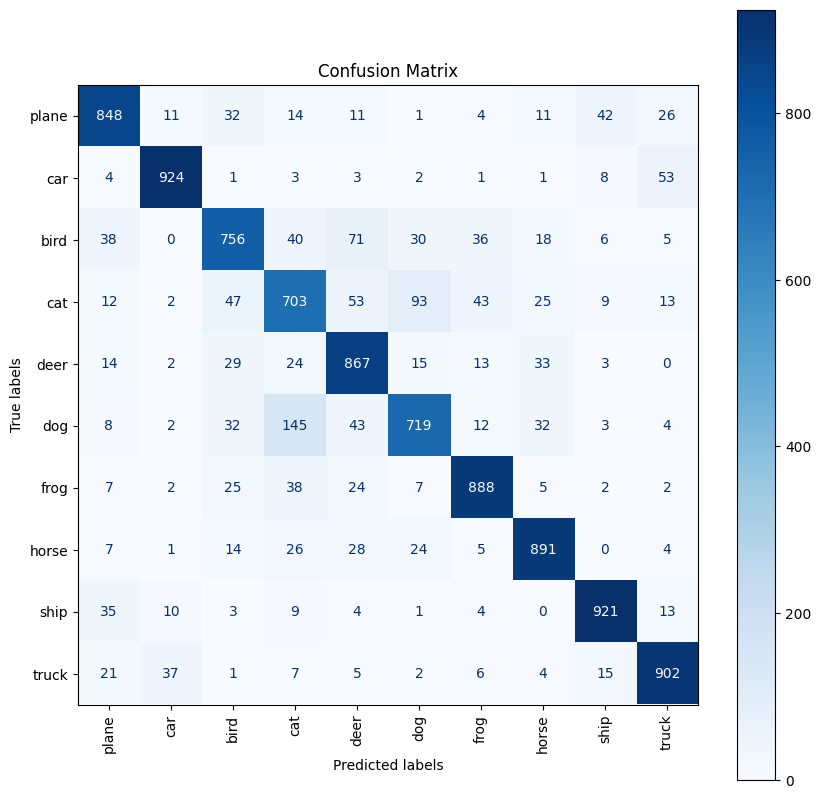

In [12]:
labels = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Classification Report')
print(classification_report(actual, pred))
cm = confusion_matrix(actual, pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels)
plt.show()